In [1]:
import tensorflow as tf
import numpy as np
from utils import read_mnist_data, plot_images
from tfops import fc
from time import time
from os.path import exists

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


In [16]:
def log(x):
    return tf.maximum(1e-8, tf.log(x))

In [22]:
tf.reset_default_graph()

z_dim = 32

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    epsilon = tf.placeholder(tf.float32, (None, z_dim), 'epsilon')
    
with tf.name_scope('encoder'):
    z_mean = fc(x, z_dim, 'sigmoid', 'z_mean')
    z_std = fc(x, z_dim, 'sigmoid', 'z_std')
    with tf.name_scope('latent-space'):
        z = epsilon * z_std + z_mean
    
with tf.name_scope('decoder'):
    x_gen = fc(z, 784, 'sigmoid', 'decode')
    
with tf.name_scope('optimize'):
    generation_loss = tf.reduce_mean((x - x_gen)**2, name='generation_loss')
    tf.summary.scalar('generation_loss', generation_loss)
    
    latent_loss = tf.reduce_mean(0.5 * tf.reduce_sum(z_mean ** 2 + z_std ** 2 - tf.log(z_std ** 2) - 1, axis=1))
    tf.summary.scalar('latent_loss', latent_loss)
    
    loss = generation_loss + 1e-3 * latent_loss
    tf.summary.scalar('loss', loss)
    
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
summ = tf.summary.merge_all()

In [18]:
def plot_reconstructions(session):
    img_idx = np.random.randint(0, data.validation.num_examples, 11)
    noise = np.random.randn(11, z_dim)
    
    original_img = data.validation.images[img_idx]
    generated_img = session.run(x_gen, {x: original_img, epsilon: noise})
    
    plot_images(original_img)
    plot_images(generated_img)

In [19]:
def plot_generated_img(session):
    noise = np.random.randn(11, z_dim)
    generated_img = session.run(x_gen, {z: noise})
    plot_images(generated_img)

In [20]:
batch_size = 256
batches_per_epoch = int(data.train.num_examples / batch_size)

def optimize(epochs):
    start_time = time()
    
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('checkpoints/VAE')
        writer.add_graph(tf.get_default_graph())
        
        saver = tf.train.Saver()
        
        if exists('checkpoints/VAE-Classifier/VAE.data-00000-of-00001'):
            saver.restore(sess, 'checkpoints/VAE/VAE')
        else:
            sess.run(tf.global_variables_initializer())
            
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch, y_batch = data.train.next_batch(batch_size)
                noise = np.random.randn(batch_size, z_dim)
                sess.run(optimizer, {x: x_batch, epsilon: noise})
                
                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, {x: x_batch, epsilon: noise}), global_step=epoch * batches_per_epoch + batch)
                    
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_reconstructions(sess)
            
        saver.save(sess, 'checkpoints/VAE/VAE', write_meta_graph=False)
            
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

INFO:tensorflow:Restoring parameters from checkpoints/VAE/VAE
Reconstructions:


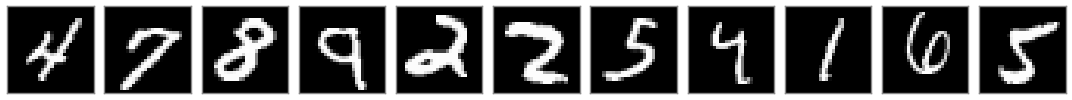

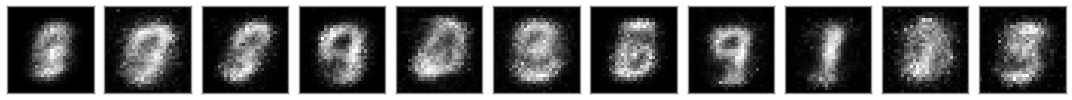

Generated:


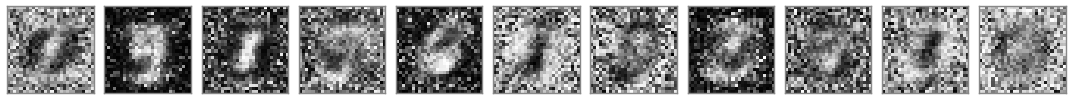

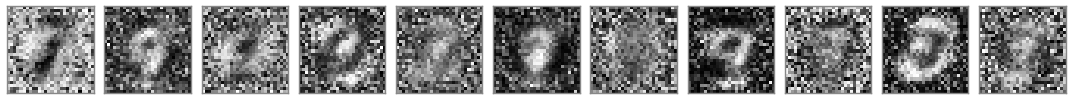

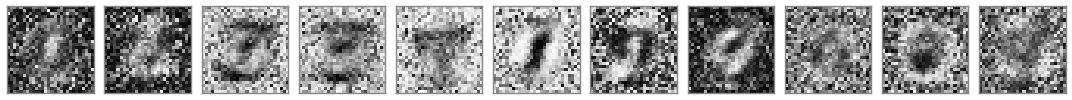

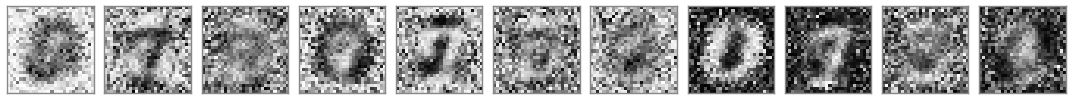

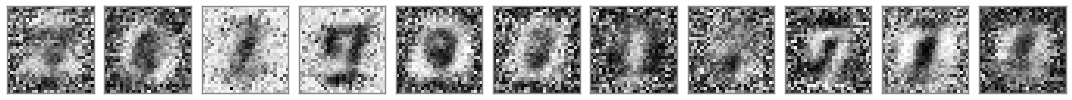

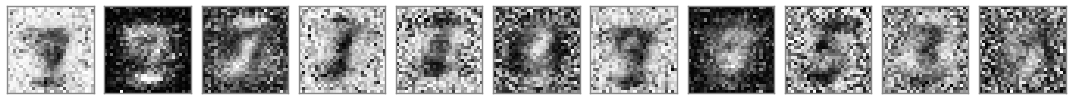

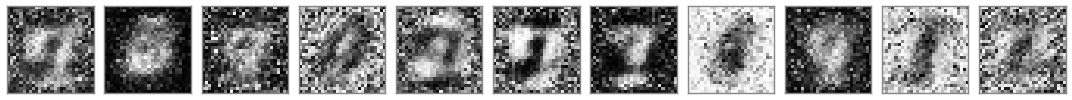

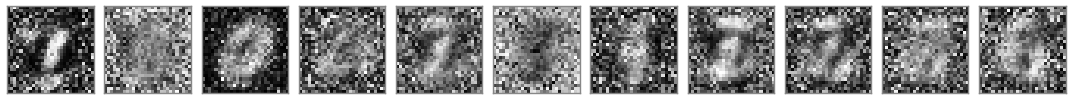

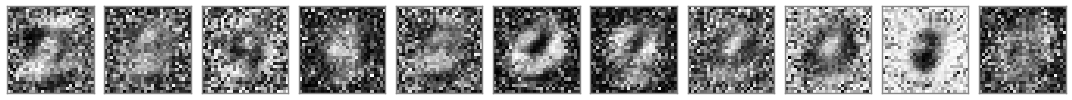

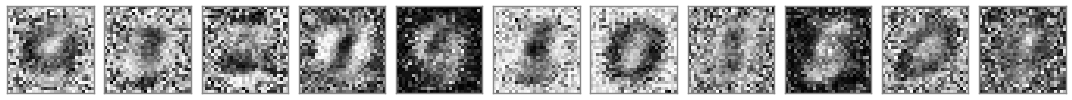

In [24]:
if exists('checkpoints/VAE/VAE.data-00000-of-00001'):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/VAE/VAE')
        
        print("Reconstructions:")
        plot_reconstructions(sess)
        
        print("Generated:")
        for _ in range(10):
            plot_generated_img(sess)
else:
    optimize(30)